Plotting complete, saved to: ../../results/04_conj_enh_opp_sup/Fig05_c_o_all.eps


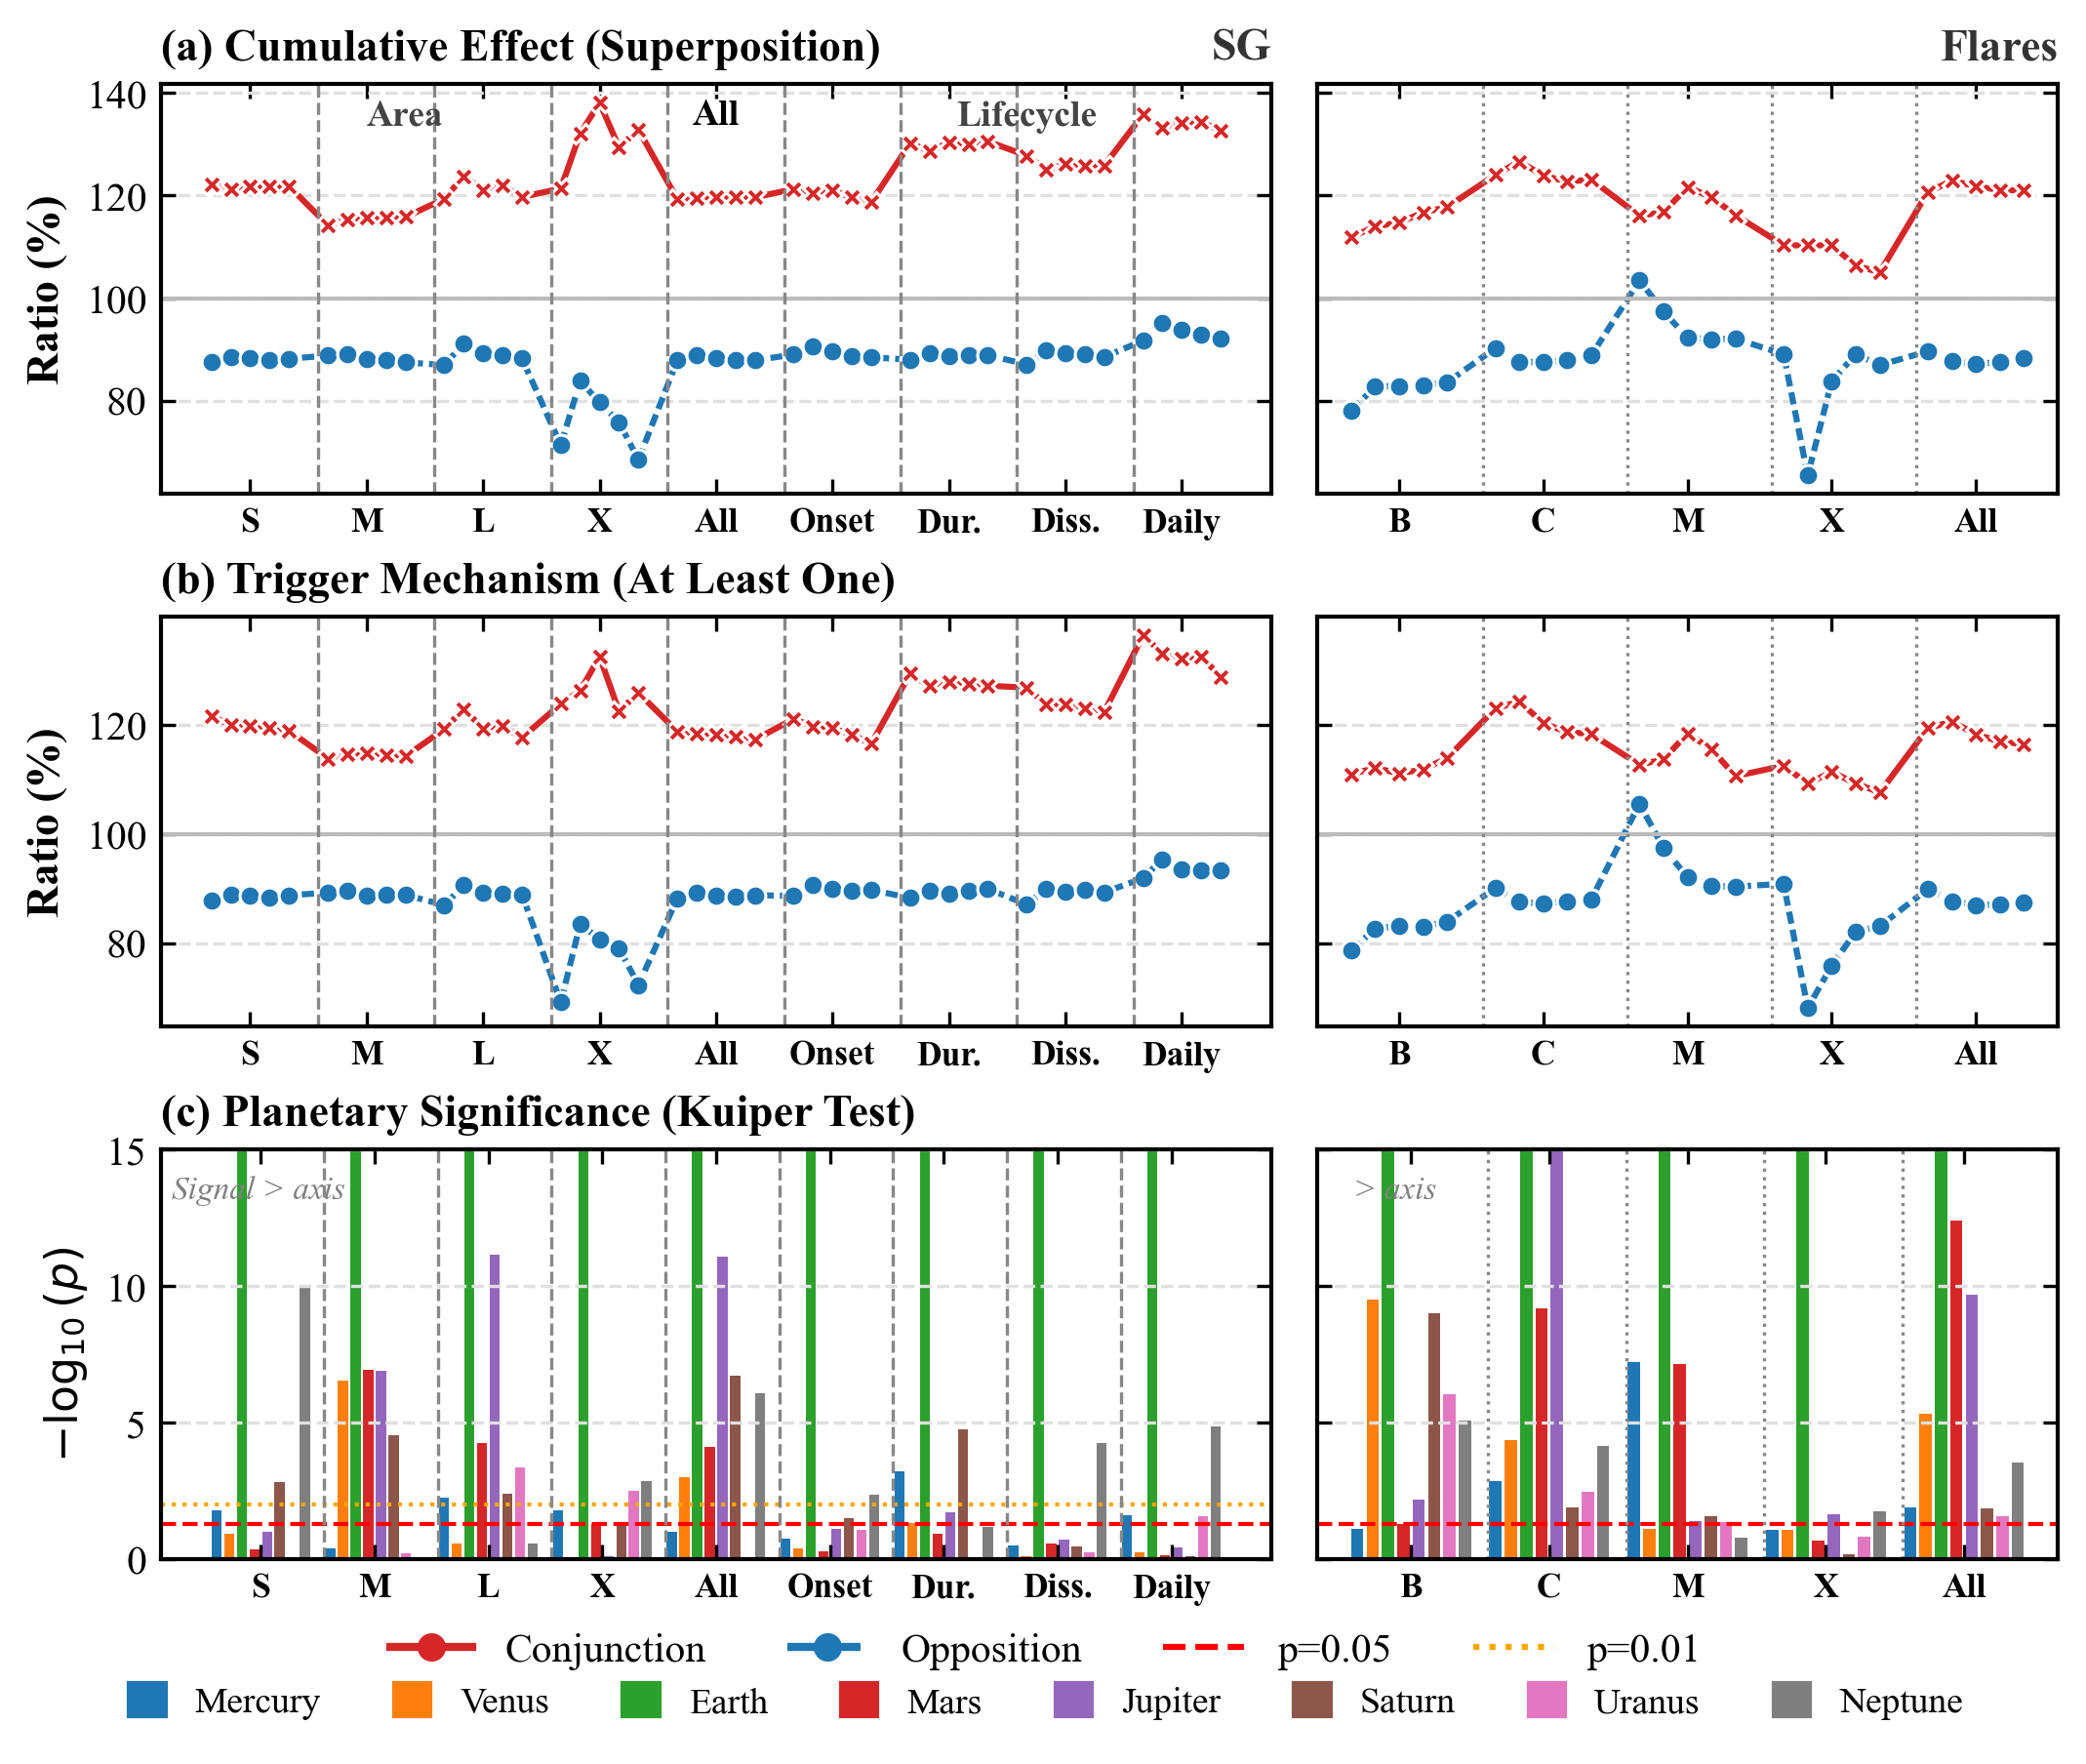

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import os

# =============================================================================
# 1. Global Configuration (EPS Standard)
# =============================================================================

def setup_astro_style():
    plt.style.use('default') 
    plt.rcParams.update({
        'font.family': 'serif',
        'font.serif': ['Times New Roman'],
        'font.size': 11,
        'axes.labelsize': 11,
        'axes.titlesize': 11,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        'axes.linewidth': 1.0,
        'lines.linewidth': 1.8,
        'xtick.direction': 'in', 'ytick.direction': 'in',
        'xtick.top': True, 'ytick.right': True,
        'figure.dpi': 300,
        'savefig.bbox': 'tight',
        'ps.fonttype': 42,      # Keep text editable
        'axes.unicode_minus': False
    })
setup_astro_style()

BASE_DATA_DIR = '../../results/04_conj_enh_opp_sup/' 

FILES = {
    'SG': {
        'A1': os.path.join(BASE_DATA_DIR, 'sg/sg_algo1_total_pairs.csv'),
        'A2': os.path.join(BASE_DATA_DIR, 'sg/sg_algo2_at_least_one.csv'),
        'KP': os.path.join(BASE_DATA_DIR, 'sg/sg_algo_kuiper_test.csv')
    },
    'SF': {
        'A1': os.path.join(BASE_DATA_DIR, 'sf/sf_algo1_total_pairs.csv'),
        'A2': os.path.join(BASE_DATA_DIR, 'sf/sf_algo2_at_least_one.csv'),
        'KP': os.path.join(BASE_DATA_DIR, 'sf/sf_algo_kuiper_test.csv')
    }
}

# --- Label Mapping ---
SG_LABELS_MAP = {
    'Small': 'S',   'Medium': 'M', 'Large': 'L', 'XLarge': 'X',
    'Global': 'All',
    'Onset': 'Onset',  
    'Duration': 'Dur.', 
    'Dissipation': 'Diss.', 
    'Daily': 'Daily'
}
SF_LABELS_MAP = {'B-Class':'B', 'C-Class':'C', 'M-Class':'M', 'X-Class':'X', 'Total':'All'}

# SG Total 9 categories
SG_COMPOSITE_RULES = [
    ('All', 'Small <100', 'Small'),         # idx 0
    ('All', 'Medium 100-500', 'Medium'),    # idx 1
    ('All', 'Large 500-2000', 'Large'),     # idx 2
    ('All', 'XLarge >2000', 'XLarge'),      # idx 3
    ('All', 'Total', 'Global'),             # idx 4
    ('Onset', 'Total', 'Onset'),            # idx 5
    ('Duration', 'Total', 'Duration'),      # idx 6
    ('Dissipation', 'Total', 'Dissipation'),# idx 7
    ('Daily', 'Total', 'Daily')             # idx 8
]

SF_GROUPS = ['B-Class', 'C-Class', 'M-Class', 'X-Class', 'Total']

PLANET_ORDER = ['199_lon', '299_lon', '399_lon', '499_lon', '599_lon', '699_lon', '799_lon', '899_lon']
PLANET_LABELS_LEGEND = ['Mercury', 'Venus', 'Earth', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune']
STEP_LINE = 6
STEP_BAR = 9

# Colors without transparency
COLOR_GRID = '#E0E0E0'     
COLOR_REF_LINE = '#BBBBBB' 
COLOR_SEP_LINE = '#888888'

# =============================================================================
# 2. Data Processing
# =============================================================================

def load_data(path):
    if not os.path.exists(path): return None
    try:
        df = pd.read_csv(path)
        df.columns = [c.strip() for c in df.columns]
        for col in ['Stage', 'Group', 'Type', 'Planet']:
            if col in df.columns:
                df[col] = df[col].astype(str).str.strip()
        return df
    except: return None

def prepare_sg_composite(df, row_type='line'):
    if df is None or df.empty: return None, [], []
    combined, ticks, separators = [], [], []
    x_offset = 0
    current_step = STEP_LINE if row_type == 'line' else STEP_BAR
    
    num_rules = len(SG_COMPOSITE_RULES)
    
    for i, (stage_cond, group_cond, label_key) in enumerate(SG_COMPOSITE_RULES):
        subset = df[(df['Stage'] == stage_cond) & (df['Group'] == group_cond)].copy()
        if not subset.empty:
            combined.append(process_coordinates(subset, row_type, x_offset))
        
        short_label = SG_LABELS_MAP.get(label_key, label_key) 
        ticks.append((x_offset + current_step / 2.0, short_label))
        
        if i < num_rules - 1:
            separators.append(x_offset + current_step)
            
        x_offset += current_step
        
    if not combined: return None, [], []
    return pd.concat(combined), ticks, separators

def prepare_sf_standard(df, row_type='line'):
    if df is None or df.empty: return None, [], []
    if 'Stage' in df.columns and 'Flare_All' in df['Stage'].unique():
        df = df[df['Stage'] == 'Flare_All']

    combined, ticks, separators = [], [], []
    x_offset = 0
    current_step = STEP_LINE if row_type == 'line' else STEP_BAR
    
    for i, group in enumerate(SF_GROUPS):
        subset = df[df['Group'] == group].copy()
        if not subset.empty:
            combined.append(process_coordinates(subset, row_type, x_offset))
            
        short_label = SF_LABELS_MAP.get(group, group[0])
        ticks.append((x_offset + current_step / 2.0, short_label))
        
        if i < len(SF_GROUPS) - 1:
            separators.append(x_offset + current_step)
        x_offset += current_step
        
    if not combined: return None, [], []
    return pd.concat(combined), ticks, separators

def process_coordinates(subset, row_type, x_offset):
    if row_type == 'line':
        subset = subset.sort_values('Window')
        subset['X_Continuous'] = subset['Window'] + x_offset
        return subset
    else:
        existing = subset['Planet'].unique()
        for p in PLANET_ORDER:
            if p not in existing:
                mock = subset.iloc[0:1].copy()
                mock['Planet'] = p; mock['p_value'] = 1.0
                subset = pd.concat([subset, mock])
        subset['Planet_Cat'] = pd.Categorical(subset['Planet'], categories=PLANET_ORDER, ordered=True)
        subset = subset.sort_values('Planet_Cat')
        subset['X_Continuous'] = np.arange(len(subset)) + 1 + x_offset
        subset['neg_log_p'] = -np.log10(subset['p_value'].replace(0, 1e-300))
        return subset

# =============================================================================
# 3. Main Plotting Program
# =============================================================================

def plot_final_macro_view():
    # [Modified] Slightly reduce height to make the overall proportions more coordinated
    fig = plt.figure(figsize=(7.2, 6.3))
    
    # [Key Modification] Change grid to 2 columns, width ratio set to 3:2
    # This way sunspots take 60%, flares take 40%, visually more balanced
    gs = gridspec.GridSpec(3, 2, width_ratios=[3, 2], wspace=0.05, hspace=0.30)
    
    rows_meta = [
        {'key': 'A1', 'title': 'Cumulative Effect (Superposition)', 'type': 'line', 'ylab': 'Ratio (%)'},
        {'key': 'A2', 'title': 'Trigger Mechanism (At Least One)', 'type': 'line', 'ylab': 'Ratio (%)'},
        {'key': 'KP', 'title': 'Planetary Significance (Kuiper Test)', 'type': 'bar', 'ylab': r'$-\log_{10}(p)$'}
    ]
    
    colors_line = {'Conjunction': '#d62728', 'Opposition': '#1f77b4'} 
    planet_colors = sns.color_palette("tab10", 8) 
    
    for row_idx, meta in enumerate(rows_meta):
        # 1. Unified Y-axis calculation
        df_sg_raw = load_data(FILES['SG'][meta['key']])
        df_sg, ticks_sg, seps_sg = prepare_sg_composite(df_sg_raw, meta['type'])
        
        df_sf_raw = load_data(FILES['SF'][meta['key']])
        df_sf, ticks_sf, seps_sf = prepare_sf_standard(df_sf_raw, meta['type'])
        
        y_min_unified, y_max_unified = 0, 0
        
        if meta['type'] == 'line':
            vals_sg = df_sg['Ratio'] if df_sg is not None else pd.Series([100])
            vals_sf = df_sf['Ratio'] if df_sf is not None else pd.Series([100])
            vmin = min(vals_sg.min(), vals_sf.min())
            vmax = max(vals_sg.max(), vals_sf.max())
            padding = (vmax - vmin) * 0.05
            y_min_unified = vmin - padding
            y_max_unified = vmax + padding
        else:
            vals_sg = df_sg['neg_log_p'] if df_sg is not None else pd.Series([0])
            vals_sf = df_sf['neg_log_p'] if df_sf is not None else pd.Series([0])
            global_max_raw = max(vals_sg.max(), vals_sf.max())
            truncation_limit = 15.0 
            if global_max_raw > truncation_limit:
                y_max_unified = truncation_limit
            else:
                y_max_unified = global_max_raw * 1.2
            y_min_unified = 0

        # ------------------------------------------------
        # Left plot: Sunspots (SG) - [Modified] Occupies the 1st column (index 0)
        # ------------------------------------------------
        ax_sg = fig.add_subplot(gs[row_idx, 0])
        
        if df_sg is not None:
            if meta['type'] == 'line':
                sns.lineplot(
                    data=df_sg, x='X_Continuous', y='Ratio', hue='Type', style='Type',
                    markers=True, markersize=5, linewidth=1.5,
                    dashes={'Conjunction': (1,0), 'Opposition': (2,1)},
                    palette=colors_line, ax=ax_sg, legend=False
                )
                ax_sg.axhline(100, color=COLOR_REF_LINE, lw=1.0)
            else:
                c_map = {p: planet_colors[i] for i, p in enumerate(PLANET_ORDER)}
                bar_cols = [c_map.get(p, '#333') for p in df_sg['Planet']]
                ax_sg.bar(df_sg['X_Continuous'], df_sg['neg_log_p'], color=bar_cols, width=0.8)
                ax_sg.axhline(1.3, c='red', ls='--', lw=1); ax_sg.axhline(2.0, c='orange', ls=':', lw=1)
                if vals_sg.max() > y_max_unified:
                     ax_sg.text(0.01, 0.88, "Signal > axis", transform=ax_sg.transAxes, fontsize=8, color='gray', style='italic')

            for sep in seps_sg:
                ax_sg.axvline(sep + 0.5, color=COLOR_SEP_LINE, linestyle='--', linewidth=0.8)

            if row_idx == 0:
                ax_sg.text(0.22, 0.96, "Area", transform=ax_sg.transAxes, ha='center', va='top', fontsize=9, fontweight='bold', color='#444')
                ax_sg.text(0.50, 0.96, "All", transform=ax_sg.transAxes, ha='center', va='top', fontsize=9, fontweight='bold', color='#000')
                ax_sg.text(0.78, 0.96, "Lifecycle", transform=ax_sg.transAxes, ha='center', va='top', fontsize=9, fontweight='bold', color='#444')
            
            left_title = f"({chr(97+row_idx)}) {meta['title']}"
            right_label = "SG" if row_idx == 0 else ""
            ax_sg.set_title(left_title, loc='left', fontsize=11, fontweight='bold')
            if right_label:
                ax_sg.set_title(right_label, loc='right', fontsize=11, fontweight='bold', color='#333')

            ax_sg.set_ylim(y_min_unified, y_max_unified)
            ax_sg.set_xticks([x for x, l in ticks_sg])
            ax_sg.set_xticklabels([l for x, l in ticks_sg], fontweight='bold', fontsize=8.5)
            ax_sg.set_ylabel(meta['ylab'], fontweight='bold')
            ax_sg.set_xlabel('')
            ax_sg.grid(axis='y', ls='--', color=COLOR_GRID)

        # ------------------------------------------------
        # Right plot: Flares (SF) - [Modified] Occupies the 2nd column (index 1)
        # ------------------------------------------------
        ax_sf = fig.add_subplot(gs[row_idx, 1])
        
        if df_sf is not None:
            if meta['type'] == 'line':
                sns.lineplot(
                    data=df_sf, x='X_Continuous', y='Ratio', hue='Type', style='Type',
                    markers=True, markersize=5, linewidth=1.5,
                    dashes={'Conjunction': (1,0), 'Opposition': (2,1)},
                    palette=colors_line, ax=ax_sf, legend=False
                )
                ax_sf.axhline(100, color=COLOR_REF_LINE, lw=1.0)
            else:
                c_map = {p: planet_colors[i] for i, p in enumerate(PLANET_ORDER)}
                bar_cols = [c_map.get(p, '#333') for p in df_sf['Planet']]
                ax_sf.bar(df_sf['X_Continuous'], df_sf['neg_log_p'], color=bar_cols, width=0.8)
                ax_sf.axhline(1.3, c='red', ls='--', lw=1)
                if vals_sf.max() > y_max_unified:
                    ax_sf.text(0.05, 0.88, "> axis", transform=ax_sf.transAxes, fontsize=8, color='gray', style='italic')

            for sep in seps_sf:
                ax_sf.axvline(sep + 0.5, color=COLOR_SEP_LINE, linestyle=':', linewidth=0.8)

            if row_idx == 0:
                ax_sf.set_title("Flares", loc='right', fontsize=11, fontweight='bold', color='#333')

            ax_sf.set_ylim(y_min_unified, y_max_unified)
            ax_sf.set_yticklabels([]) 
            ax_sf.set_xticks([x for x, l in ticks_sf])
            ax_sf.set_xticklabels([l for x, l in ticks_sf], fontweight='bold', fontsize=8.5)
            ax_sf.set_ylabel('')
            ax_sf.set_xlabel('')
            ax_sf.grid(axis='y', ls='--', color=COLOR_GRID)

    # ------------------------------------------------
    # Bottom Legend
    # ------------------------------------------------
    logic_handles = [
        mlines.Line2D([], [], color='#d62728', marker='o', markersize=6, label='Conjunction', linestyle='-', lw=2),
        mlines.Line2D([], [], color='#1f77b4', marker='o', markersize=6, label='Opposition', linestyle='--', lw=2),
        mlines.Line2D([], [], color='red', linestyle='--', lw=1.5, label='p=0.05'),
        mlines.Line2D([], [], color='orange', linestyle=':', lw=1.5, label='p=0.01')
    ]
    planet_handles = [
        mpatches.Patch(color=planet_colors[i], label=PLANET_LABELS_LEGEND[i]) 
        for i in range(8)
    ]

    leg1 = fig.legend(handles=logic_handles, loc='lower center', 
                      bbox_to_anchor=(0.5, 0.04), ncol=4, frameon=False, fontsize=10)
    fig.legend(handles=planet_handles, loc='lower center', 
               bbox_to_anchor=(0.5, 0.015), ncol=8, frameon=False, fontsize=9,
               handlelength=1.0, handleheight=1.0)

    plt.subplots_adjust(top=0.92, bottom=0.12, left=0.08, right=0.98)
    
    save_path = '../../results/04_conj_enh_opp_sup/Fig05_c_o_all.eps'
    plt.savefig(save_path, format='eps')
    print(f"Plotting complete, saved to: {save_path}")

if __name__ == '__main__':
    plot_final_macro_view()